## Named Entity Recognition Task SystemA (MultiNERD Dataset)

### XLNET Base Cased

[MultiNERD Dataset] 🤗: https://huggingface.co/datasets/Babelscape/multinerd 

[xlnet Base Cased Model] 🤗: https://huggingface.co/xlnet-base-cased

#### Import Necessary Libraries

* [AutoTokenizer](https://huggingface.co/transformers/model_doc/auto.html#transformers.AutoTokenizer): A tokenizer class designed to accommodate the tokenization conventions of various pre-trained models.

* [AutoModelForTokenClassification](https://huggingface.co/transformers/model_doc/auto.html#automodelfortokenclassification): An extension of the [AutoModel](https://huggingface.co/transformers/model_doc/auto.html#transformers.AutoModel) class, capable of loading diverse pre-trained models. It supports fine-tuning for the classification of each token within a sequence.

* [TrainingArguments](https://huggingface.co/transformers/main_classes/trainer.html#transformers.TrainingArguments): A straightforward class tailored for storing hyperparameters and other settings essential for model training.

* [Trainer](https://huggingface.co/transformers/main_classes/trainer.html): A versatile class that facilitates various forms of training for transformer models.

* [DataCollatorForTokenClassification](https://github.com/huggingface/transformers/blob/master/src/transformers/data/data_collator.py): A class designed for padding token classification examples to the same length during training.

* [load_dataset](https://huggingface.co/docs/datasets/package_reference/loading_methods.html#datasets.load_dataset): A function crafted for effortlessly loading datasets, including those from the [datasets](https://huggingface.co/datasets) collection.


In [1]:
import os, sys
os.environ['TOKENIZERS_PARALLELISM']='false'

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import sklearn
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import datasets
from datasets import load_dataset, DatasetDict

import torch
from torch import nn
from torch.nn.functional import cross_entropy

import transformers
from transformers import AutoTokenizer, AutoModelForTokenClassification
from transformers import DataCollatorForTokenClassification
from transformers import Trainer, TrainingArguments

import evaluate



/srv/users/rudxia/anaconda3/envs/NLP/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


#### Extracting English Subset of Dataset as input of SystemA

* First load the dataset with [`load_dataset`](https://huggingface.co/docs/datasets/package_reference/loading_methods.html#datasets.load_dataset), Then Filter out the non-English examples of the dataset as the training dataset of the SystemA.

* System A supposed to be a fine-tuned XLNET model on the English subset of the training set.

* The loaded dataset is a dictionary-like container for [`Dataset`](https://huggingface.co/docs/datasets/exploring.html) objects for training, development (validation), and test data. We'll here be using the `tokens` and `ner_tags` fields and ignoring `lang` (language).

In [2]:

original_dataset = load_dataset('Babelscape/multinerd')
data = original_dataset.filter(lambda example: example['lang'] == 'en')
data = data.remove_columns(["lang"])
label_list = ['O',
 'B-EVE',
 'I-EVE',
 'B-LOC',
 'B-MEDIA',
 'I-MEDIA',
 'I-PER',
 'B-PER',
 'B-DIS',
 'I-LOC',
 'B-PLANT',
 'B-FOOD',
 'B-VEHI',
 'I-VEHI',
 'I-ORG',
 'I-FOOD',
 'B-ORG',
 'B-TIME',
 'B-ANIM',
 'B-CEL',
 'I-TIME',
 'B-MYTH',
 'I-MYTH',
 'I-DIS',
 'I-ANIM',
 'B-INST',
 'I-PLANT',
 'B-BIO',
 'I-INST',
 'I-CEL',
 'I-BIO']
num_labels = len(label_list)

Resolving data files: 100%|██████████| 20/20 [00:00<00:00, 159176.62it/s]


#### Split Dataset into DatasetDict

In [3]:
ds = DatasetDict({
    'train': data['train'], 
    'eval': data['validation'], 
    'test': data['test']})

print('Training data shape:', ds['train'].shape)
print('Validation data shape:', ds['eval'].shape)
print('Testing data shape:', ds['test'].shape)

Training data shape: (262560, 2)
Validation data shape: (32820, 2)
Testing data shape: (32908, 2)


#### Example

In [4]:
example = ds['train'][12]
example

{'tokens': ['The',
  'wild',
  'bulb',
  'vernal',
  'squill',
  'is',
  'known',
  'locally',
  'as',
  '"',
  'grice',
  "'s",
  'onions',
  '"',
  'because',
  'it',
  'was',
  'a',
  'favourite',
  'food',
  'of',
  'the',
  'swine',
  '.'],
 'ner_tags': [0,
  0,
  0,
  25,
  26,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0]}

#### Display Feature Information About Each Feature

In [5]:
for k, v in ds["train"].features.items():
    print(f"{k}: \n{v}\n")

tokens: 
Sequence(feature=Value(dtype='string', id=None), length=-1, id=None)

ner_tags: 
Sequence(feature=Value(dtype='int64', id=None), length=-1, id=None)



#### Define Tag Values & Conversions Between String & Integer Values

In [6]:
label2id = {
    "O": 0,
    "B-PER": 1,
    "I-PER": 2,
    "B-ORG": 3,
    "I-ORG": 4,
    "B-LOC": 5,
    "I-LOC": 6,
    "B-ANIM": 7,
    "I-ANIM": 8,
    "B-BIO": 9,
    "I-BIO": 10,
    "B-CEL": 11,
    "I-CEL": 12,
    "B-DIS": 13,
    "I-DIS": 14,
    "B-EVE": 15,
    "I-EVE": 16,
    "B-FOOD": 17,
    "I-FOOD": 18,
    "B-INST": 19,
    "I-INST": 20,
    "B-MEDIA": 21,
    "I-MEDIA": 22,
    "B-MYTH": 23,
    "I-MYTH": 24,
    "B-PLANT": 25,
    "I-PLANT": 26,
    "B-TIME": 27,
    "I-TIME": 28,
    "B-VEHI": 29,
    "I-VEHI": 30,
  }

id2label = {tag: idx for idx, tag in label2id.items()}

pos_tag_values = list(label2id.keys())
NUM_OF_LABELS = len(pos_tag_values)

print(f"List of tag values: \n{pos_tag_values}")
print(f"Number of NER Tags: \n{NUM_OF_LABELS}")
print(f"id2label: \n{id2label}")
print(f"label2id: \n{label2id}")

List of tag values: 
['O', 'B-PER', 'I-PER', 'B-ORG', 'I-ORG', 'B-LOC', 'I-LOC', 'B-ANIM', 'I-ANIM', 'B-BIO', 'I-BIO', 'B-CEL', 'I-CEL', 'B-DIS', 'I-DIS', 'B-EVE', 'I-EVE', 'B-FOOD', 'I-FOOD', 'B-INST', 'I-INST', 'B-MEDIA', 'I-MEDIA', 'B-MYTH', 'I-MYTH', 'B-PLANT', 'I-PLANT', 'B-TIME', 'I-TIME', 'B-VEHI', 'I-VEHI']
Number of NER Tags: 
31
id2label: 
{0: 'O', 1: 'B-PER', 2: 'I-PER', 3: 'B-ORG', 4: 'I-ORG', 5: 'B-LOC', 6: 'I-LOC', 7: 'B-ANIM', 8: 'I-ANIM', 9: 'B-BIO', 10: 'I-BIO', 11: 'B-CEL', 12: 'I-CEL', 13: 'B-DIS', 14: 'I-DIS', 15: 'B-EVE', 16: 'I-EVE', 17: 'B-FOOD', 18: 'I-FOOD', 19: 'B-INST', 20: 'I-INST', 21: 'B-MEDIA', 22: 'I-MEDIA', 23: 'B-MYTH', 24: 'I-MYTH', 25: 'B-PLANT', 26: 'I-PLANT', 27: 'B-TIME', 28: 'I-TIME', 29: 'B-VEHI', 30: 'I-VEHI'}
label2id: 
{'O': 0, 'B-PER': 1, 'I-PER': 2, 'B-ORG': 3, 'I-ORG': 4, 'B-LOC': 5, 'I-LOC': 6, 'B-ANIM': 7, 'I-ANIM': 8, 'B-BIO': 9, 'I-BIO': 10, 'B-CEL': 11, 'I-CEL': 12, 'B-DIS': 13, 'I-DIS': 14, 'B-EVE': 15, 'I-EVE': 16, 'B-FOOD': 17, 'I-

In the text classification tasks discussed earlier, each data example included a string representing an entire sentence. In contrast, the current data is already segmented into words, denoted by the key `tokens` in the `Dataset` object. Interestingly, the tags in the data correspond to these individual words. Let's examine a sample sentence for better clarity.

In [7]:
train_words = ds['train']['tokens']
train_tags = ds['train']['ner_tags']
for word, tag in zip(train_words[0], train_tags[0]):
    print(f'{word:8s} ➔ {label_list[tag]}')

The      ➔ O
type     ➔ O
locality ➔ O
is       ➔ O
Kīlauea  ➔ I-MEDIA
.        ➔ O


Aligning labels (tags) with words, especially when they don't align perfectly with the tokenization of the model, introduces significant complexity. This becomes more apparent once we've loaded a tokenizer.

#### Fundamental Constants and Parameters Configuration

Let's establish critical global variables encompassing the designation of the pre-trained model and the essential hyperparameters instrumental for its meticulous fine-tuning:

* `MODEL_CKPT`: The nomenclature of a pre-trained model accessible within the [model repository](https://huggingface.co/models).
* `REPORTS_TO`: Incorporating visualization tools vital for comprehensive machine learning experimentation, opt for [TensorBoard](https://www.tensorflow.org/tensorboard) in this context.
* `LR`, `WEIGHT_DECAY`, `BATCH_SIZE`, `STEPS`, and `NUM_OF_EPOCHS`: Configurable hyperparameters governing the nuanced fine-tuning process of the model. (Experimenting with diverse values is encouraged!)
* `OUTPUT_DIR` and `LOG_DIR`: The designated directories for storing the model and its associated parameters.
* `DEVICE` : The computational device on which the model training is executed. In this instance, utilize GPU for optimal training efficiency.

In [8]:
MODEL_CKPT = "xlnet-base-cased"
MODEL_NAME = f"{MODEL_CKPT}-finetuned-MultiNERD-SystemA"

NUM_OF_EPOCHS = 5
BATCH_SIZE = 8

STRATEGY = "epoch"
REPORTS_TO = "tensorboard"

WEIGHT_DECAY = 0.01
LR = 2e-5

# DEVICE = torch.device("cpu")
STEPS = 1250

OUTPUT_DIR = f'/srv/users/rudxia/Developer_NLP/notebooks/results/Outdir/{MODEL_CKPT}-finetuned-MultiNERD-SystemA'
LOG_DIR= f'/srv/users/rudxia/Developer_NLP/notebooks/results/Log/{MODEL_CKPT}-finetuned-MultiNERD-SystemA'


if torch.cuda.is_available():
    DEVICE = torch.device("cuda")
    print("CUDA is available. Using GPU.")

CUDA is available. Using GPU.


#### Function to Tokenize & Align Inputs

Ensuring the alignment of labels (tags) with words that might not align perfectly with the model involves loading a suitable tokenizer using [`AutoTokenizer.from_pretrained`](https://huggingface.co/transformers/model_doc/auto.html#transformers.AutoTokenizer.from_pretrained). Specifically, we opt for a ["fast" tokenizer](https://huggingface.co/transformers/main_classes/tokenizer.html) since it offers a mapping from tokens to input words, a crucial requirement for Named Entity Recognition (NER).

In [9]:
# tokenizer = AutoTokenizer.from_pretrained(MODEL_CKPT)

# def tokenize_and_align_labels(samples):
#     tokenized_inputs = tokenizer(samples["tokens"], 
#                                       truncation=True, 
#                                       is_split_into_words=True)
    
#     labels = []
    
#     for idx, label in enumerate(samples[f"ner_tags"]):
#         word_ids = tokenized_inputs.word_ids(batch_index=idx)
#         prev_word_idx = None
#         label_ids = []
#         for word_idx in word_ids: # set special tokens to -100
#             if word_idx is None or word_idx == prev_word_idx:
#                 label_ids.append(-100)
#             else:
#                 label_ids.append(label[word_idx])
#             prev_word_idx = word_idx
#         labels.append(label_ids)
    
#     tokenized_inputs["labels"] = labels
#     return tokenized_inputs
tokenizer = AutoTokenizer.from_pretrained(MODEL_CKPT)

def tokenize_and_align_labels(samples):
    tokenized_inputs = tokenizer(samples["tokens"], 
                                      truncation=True, 
                                      is_split_into_words=True)
    
    labels = []
    
    for idx, label in enumerate(samples[f"ner_tags"]):
        word_ids = tokenized_inputs.word_ids(batch_index=idx)
        prev_word_idx = None
        label_ids = []
        for word_idx in word_ids: # set special tokens to -100
            if word_idx is None or word_idx == prev_word_idx:
                label_ids.append(-100)
            else:
                label_ids.append(label[word_idx])
            prev_word_idx = word_idx
        labels.append(label_ids)
    
    tokenized_inputs["labels"] = labels
    return tokenized_inputs

#### Apply Above Function to Tokenize Dataset

In [10]:
encoded_ds = ds.map(tokenize_and_align_labels, 
                    batched=True, 
                    remove_columns=
                        [
                            'ner_tags', 
                            'tokens'
                        ]
                    )

#### Load Custom Model

In [11]:
model = (AutoModelForTokenClassification.from_pretrained(
    MODEL_CKPT,
    num_labels=NUM_OF_LABELS,
    id2label=id2label,
    label2id=label2id
    ).to(DEVICE))

Some weights of XLNetForTokenClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


#### Create Compute Metrics Function

In [12]:
label_list = pos_tag_values

seqeval = evaluate.load("seqeval")

labels = [label_list[i] for i in example[f'ner_tags']]

def compute_metrics(eval_preds):
    predictions, labels = eval_preds
    predictions = np.argmax(predictions, 
                            axis=2)
    
    true_predictions = [
        [label_list[p] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]
    
    true_labels = [
        [label_list[l] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]
    
    results = seqeval.compute(predictions=true_predictions, 
                              references=true_labels)
    
    return results

#### Define TrainingArguments

In [13]:
args = TrainingArguments(
    OUTPUT_DIR,    # output directory for checkpoints and predictions
    MODEL_NAME,
    log_level="error",
    logging_first_step=True,
    logging_dir = LOG_DIR,
    learning_rate=LR,
    num_train_epochs=NUM_OF_EPOCHS,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    evaluation_strategy=STRATEGY,
    report_to=REPORTS_TO,
    disable_tqdm=False,
    logging_steps=STEPS,
    weight_decay=WEIGHT_DECAY,
    save_strategy=STRATEGY,
    hub_private_repo=False,
    push_to_hub=False
)

#### Define Trainer and Subclass Trainer to Handle Class Imbalance

To fine-tune the pre-trained model, we'll instantiate a [`Trainer`](https://huggingface.co/transformers/main_classes/trainer.html) object. This involves providing the pre-trained model, configuration settings, training and validation datasets, and the previously defined evaluation metric.

Most of this should be familiar from the sentence classification notebook, with one notable exception: we include a [`DataCollatorForTokenClassification`](https://github.com/huggingface/transformers/blob/master/src/transformers/data/data_collator.py) with the trainer. This class efficiently handles the padding of token classification examples in batches, ensuring they are of the same length, as required by PyTorch. The tokenizer's `[PAD]` symbol is employed for padding the output, along with the specified `label_pad_token_id` for padding the labels.

In [14]:
class CustomTrainer(Trainer):
    def compute_loss(self, 
                     model, 
                     inputs, 
                     return_outputs=False):
        
        labels = inputs.get("labels")
        # forward pass
        outputs = model(**inputs)
        logits = outputs.get("logits")
        # compute custom loss 
        loss_fct = nn.CrossEntropyLoss(weight=torch.tensor(
            [1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 
             9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0,
             16.0, 17.0, 18.0, 19.0, 20.0, 21.0, 22.0,
             23.0, 24.0, 25.0, 26.0, 27.0, 28.0, 29.0, 30.0, 31.0], 
            device=DEVICE)
        )
        loss = loss_fct(logits.view(-1, 
                                    self.model.config.num_labels), 
                        labels.view(-1)
                        )
        return (loss, outputs) if return_outputs else loss

In [15]:
data_collator = DataCollatorForTokenClassification(tokenizer=tokenizer)
trainer = CustomTrainer(model, 
                  args=args,
                  data_collator=data_collator,
                  compute_metrics=compute_metrics,
                  tokenizer=tokenizer,
                  train_dataset=encoded_ds["train"],
                  eval_dataset=encoded_ds["eval"],
                  )

Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


#### Train Model

In [16]:
train_results = trainer.train()

Epoch,Training Loss,Validation Loss,Anim,Bio,Cel,Dis,Eve,Food,Inst,Loc,Media,Myth,Org,Per,Plant,Time,Vehi,Overall Precision,Overall Recall,Overall F1,Overall Accuracy
1,0.114900,0.174275,"{'precision': 0.5322669608383894, 'recall': 0.8509700176366843, 'f1': 0.654903291482864, 'number': 2268}","{'precision': 0.8, 'recall': 0.2857142857142857, 'f1': 0.4210526315789473, 'number': 28}","{'precision': 0.7192982456140351, 'recall': 0.8723404255319149, 'f1': 0.7884615384615385, 'number': 188}","{'precision': 0.588137702198258, 'recall': 0.8365781710914454, 'f1': 0.6906965416463712, 'number': 3390}","{'precision': 0.954248366013072, 'recall': 0.9765886287625418, 'f1': 0.9652892561983473, 'number': 598}","{'precision': 0.39851971782120965, 'recall': 0.8127358490566038, 'f1': 0.5348025141615581, 'number': 4240}","{'precision': 0.6, 'recall': 0.7941176470588235, 'f1': 0.6835443037974683, 'number': 68}","{'precision': 0.9861163700618453, 'recall': 0.9952866242038216, 'f1': 0.9906802764217334, 'number': 15700}","{'precision': 0.9519230769230769, 'recall': 0.969532100108814, 'f1': 0.9606469002695418, 'number': 1838}","{'precision': 0.4727272727272727, 'recall': 0.9285714285714286, 'f1': 0.6265060240963856, 'number': 112}","{'precision': 0.9686016794450529, 'recall': 0.969309462915601, 'f1': 0.9689554419284149, 'number': 5474}","{'precision': 0.9936493081088308, 'recall': 0.990009324630345, 'f1': 0.9918259767123744, 'number': 15014}","{'precision': 0.40560904143993304, 'recall': 0.8211864406779661, 'f1': 0.5430092462874755, 'number': 2360}","{'precision': 0.7428571428571429, 'recall': 0.8074534161490683, 'f1': 0.7738095238095238, 'number': 644}","{'precision': 0.8333333333333334, 'recall': 0.8125, 'f1': 0.8227848101265822, 'number': 160}",0.794468,0.946431,0.863817,0.975456
2,0.059700,0.198247,"{'precision': 0.5816636308439587, 'recall': 0.8447971781305115, 'f1': 0.6889608054656599, 'number': 2268}","{'precision': 0.3793103448275862, 'recall': 0.7857142857142857, 'f1': 0.5116279069767441, 'number': 28}","{'precision': 0.7747747747747747, 'recall': 0.9148936170212766, 'f1': 0.8390243902439024, 'number': 188}","{'precision': 0.5737115461446265, 'recall': 0.8471976401179941, 'f1': 0.684135302525012, 'number': 3390}","{'precision': 0.9632107023411371, 'recall': 0.9632107023411371, 'f1': 0.9632107023411371, 'number': 598}","{'precision': 0.418514607532559, 'recall': 0.8412735849056604, 'f1': 0.5589594922823787, 'number': 4240}","{'precision': 0.6136363636363636, 'recall': 0.7941176470588235, 'f1': 0.6923076923076923, 'number': 68}","{'precision': 0.9891194331983806, 'recall': 0.9959235668789809, 'f1': 0.9925098387711058, 'number': 15700}","{'precision': 0.9461457233368532, 'recall': 0.9749727965179543, 'f1': 0.9603429796355841, 'number': 1838}","{'precision': 0.7692307692307693, 'recall': 0.8928571428571429, 'f1': 0.8264462809917357, 'number': 112}","{'precision': 0.9726974881689116, 'recall': 0.9762513701132627, 'f1': 0.974471188913202, 'number': 5474}","{'precision': 0.9953445065176909, 'recall': 0.9968029838817104, 'f1': 0.9960732113144759, 'number': 15014}","{'precision': 0.472289156626506, 'recall': 0.8305084745762712, 'f1': 0.6021505376344086, 'number': 2360}","{'precision': 0.5984766050054406, 'recall': 0.8540372670807453, 'f1': 0.7037747920665387, 'number': 644}","{'precision': 0.7674418604651163, 'recall': 0.825, 'f1': 0.7951807228915662, 'number': 160}",0.808884,0.953477,0.875249,0.977935
3,0.036300,0.292913,"{'precision': 0.6204188481675392, 'recall': 0.8359788359788359, 'f1': 0.7122464312546957, 'number': 2268}","{'precision': 0.4583333333333333, 'recall': 0.7857142857142857, 'f1': 0.5789473684210527, 'number': 28}","{'precision': 0.7657657657657657, 'recall': 0.9042553191489362, 'f1': 0.8292682926829268, 'number': 188}","{'precision': 0.6434977578475336, 'recall': 0.8466076696165191, 'f1': 0.7312101910828025, 'number': 3390}","{'precision': 0.9572368421052632, 'recall': 0.9732441471571907, 'f1': 0.9651741293532339, 'number': 598}","{

#### Save & Log Model

In [17]:
output_model_dir = "/srv/users/rudxia/Developer_NLP/notebooks/results/saved_model/XLNET_MultiNERD_SystemA"
trainer.save_model(output_model_dir)

In [18]:
trainer.save_model()
trainer.log_metrics("train", train_results.metrics)
trainer.save_metrics("train", train_results.metrics)
trainer.save_state()

***** train metrics *****
  epoch                    =        5.0
  total_flos               = 51453493GF
  train_loss               =     0.0659
  train_runtime            = 4:39:18.81
  train_samples_per_second =     78.335
  train_steps_per_second   =      2.448


The fine-tuned model is now available as `trainer.model`. Here we define functions to predict tags for a user-defined string.

The main complexity here arises from the need to map back from token labels to word labels, inverting the mapping performed in `encode_dataset`. The process is basically the same as in `compute_metrics` above.

In [19]:
model = trainer.model
model.eval()    # switch to evaluation mode
model.to('cpu')    # switch to CPU


def word_start_tokens(tokenized):
    """Return list of bool identifying which tokens start words."""
    prev_word_idx = None
    is_word_start = []
    for word_idx in tokenized.word_ids():
        if word_idx is None or word_idx == prev_word_idx:
            is_word_start.append(False)
        else:
            is_word_start.append(True)
        prev_word_idx = word_idx
    return is_word_start


def predict_ner(words):
    tokenized = tokenizer(words, is_split_into_words=True, return_tensors='pt')
    pred = model(**tokenized)
    pred_idx = pred.logits.detach().numpy().argmax(axis=2)
    token_labels = [label_list[i] for s in pred_idx for i in s]
    word_labels = []
    for label, is_word_start in zip(token_labels, word_start_tokens(tokenized)):
        if is_word_start:
            word_labels.append(label)
    return word_labels

Let's try that out on a couple of example sentences:

In [20]:
example_sentences = [
    'Paris, the capital of France, is known for its iconic Eiffel Tower.',
    'Elon Musk is the CEO of SpaceX and Tesla.',
    'The Great Barrier Reef is the world\'s largest coral reef system, located in Australia.',
    'Mount Everest, the highest peak in the world, is part of the Himalayan mountain range.',
    'The Mona Lisa, painted by Leonardo da Vinci, is displayed in the Louvre Museum in Paris.',
    'Barack Obama served as the 44th President of the United States from 2009 to 2017.',
    'The Amazon rainforest, often called the "lungs of the Earth," is vital for global oxygen production.',
    'Albert Einstein, a renowned physicist, developed the theory of relativity.',
    'The Nile River is the longest river in Africa, flowing through multiple countries.',
]


for e in example_sentences:
    words = e.split()    # Note: assumes white-space tokenization is OK
    ner_tags = predict_ner(words)
    for word, tag in zip(words, ner_tags):
        print(f'{word:10s} ➔ {tag}')
    print()

Paris,     ➔ B-LOC
the        ➔ O
capital    ➔ O
of         ➔ O
France,    ➔ B-LOC
is         ➔ O
known      ➔ O
for        ➔ O
its        ➔ O
iconic     ➔ O
Eiffel     ➔ B-LOC
Tower.     ➔ I-LOC

Elon       ➔ B-PER
Musk       ➔ I-PER
is         ➔ O
the        ➔ O
CEO        ➔ O
of         ➔ O
SpaceX     ➔ B-ORG
and        ➔ O
Tesla.     ➔ B-ORG

The        ➔ O
Great      ➔ B-LOC
Barrier    ➔ I-LOC
Reef       ➔ I-LOC
is         ➔ O
the        ➔ O
world's    ➔ O
largest    ➔ O
coral      ➔ O
reef       ➔ O
system,    ➔ O
located    ➔ O
in         ➔ O
Australia. ➔ B-LOC

Mount      ➔ B-LOC
Everest,   ➔ I-LOC
the        ➔ O
highest    ➔ O
peak       ➔ O
in         ➔ O
the        ➔ O
world,     ➔ O
is         ➔ O
part       ➔ O
of         ➔ O
the        ➔ O
Himalayan  ➔ B-LOC
mountain   ➔ O
range.     ➔ O

The        ➔ O
Mona       ➔ B-LOC
Lisa,      ➔ I-LOC
painted    ➔ O
by         ➔ O
Leonardo   ➔ B-PER
da         ➔ I-PER
Vinci,     ➔ I-PER
is         ➔ O
displayed  ➔ O
in         ➔ O
t

# Visualization

To get a better intuitive understanding of tagging results, let's implement a visualization using the[`displacy`](https://explosion.ai/demos/displacy-ent) library.

The code here mostly maps the IOB tags to character offets and formats the data for displacy. Unless you're interested in modifying this or otherwise working with this library, there's no need to go through this in detail.

In [21]:
from spacy import displacy
# Mapping of MultiNERD types for displacy

type_map = {

}

def render_with_displacy(words, tags):
    tagged, offset, start, label = [], 0, None, None
    for word, tag in zip(words, tags):
        if tag[0] in 'OB' and start is not None:    # current ends
            tagged.append({
                'start': start,
                'end': offset,
                'label': type_map.get(label, label)
            })
            start, label = None, None
        if tag[0] == 'B':
            start, label = offset, tag[2:]
        elif tag[0] == 'I':
            if start is None:    # I without B, but nevermind
                start, label = offset, tag[2:]
        else:
            assert tag == 'O', 'unexpected tag {}'.format(tag)
        offset += len(word) + 1    # +1 for space
    if start:    # span open at sentence end
        tagged.append({
                'start': start,
                'end': offset,
                'label': type_map.get(label, label)
        })
    doc = {
        'text': ' '.join(words),
        'ents': tagged
    }
    displacy.render(doc, style='ent', jupyter=True, manual=True)


for e in example_sentences:
    words = e.split()    # Note: assumes white-space tokenization is OK
    ner_tags = predict_ner(words)
    render_with_displacy(words, ner_tags)

In [22]:
from spacy import displacy
# Mapping of MultiNERD types for displacy

type_map = {
    'PER': 'Person',
    'LOC': 'Location',
    'ORG': 'Organization',
    'ANIM': 'Animal',
    'BIO': 'Biological entity',
    'CEL': 'Celestial Body',
    'DIS': 'Disease',
    'EVE': 'Event',
    'FOOD': 'Food',
    'INST': 'Instrument',
    'MEDIA': 'Media',
    'PLANT': 'Plant',
    'MYTH': 'Mythological entity',
    'TIME': 'Time',
    'VEHI': 'Vehicle',
}

def render_with_displacy(words, tags):
    tagged, offset, start, label = [], 0, None, None
    for word, tag in zip(words, tags):
        if tag[0] in 'OB' and start is not None:    # current ends
            tagged.append({
                'start': start,
                'end': offset,
                'label': type_map.get(label, label)
            })
            start, label = None, None
        if tag[0] == 'B':
            start, label = offset, tag[2:]
        elif tag[0] == 'I':
            if start is None:    # I without B, but nevermind
                start, label = offset, tag[2:]
        else:
            assert tag == 'O', 'unexpected tag {}'.format(tag)
        offset += len(word) + 1    # +1 for space
    if start:    # span open at sentence end
        tagged.append({
                'start': start,
                'end': offset,
                'label': type_map.get(label, label)
        })
    doc = {
        'text': ' '.join(words),
        'ents': tagged
    }
    displacy.render(doc, style='ent', jupyter=True, manual=True)


for e in example_sentences:
    words = e.split()    # Note: assumes white-space tokenization is OK
    ner_tags = predict_ner(words)
    render_with_displacy(words, ner_tags)

### Error Analysis

#### Define Method to Apply to Validation Dataset (& Then Apply it)

In [133]:
def forward_pass_with_label(batch):
    # Convert dict of lists to list of dicts suitable for data collator
    features = [dict(zip(batch, t)) for t in zip(*batch.values())]
    # Pad inputs and labels and put all tensors on device
    batch = data_collator(features)
    input_ids = batch["input_ids"].to('cpu')
    attention_mask = batch["attention_mask"].to('cpu')
    labels = batch["labels"].to('cpu')
    with torch.no_grad():
        # Pass data through model  
        output = trainer.model(input_ids, 
                               attention_mask
                               )
        # Logit.size: [batch_size, sequence_length, classes]
        predicted_label = torch.argmax(output.logits, 
                                       axis=-1
                                       ).cpu().numpy()
        
    # Calculate loss per token after flattening batch dimension with view
    loss = cross_entropy(output.logits.view(-1, 31), 
                         labels.view(-1), 
                         reduction="none")
    # Unflatten batch dimension and convert to numpy array
    loss = loss.view(len(input_ids), -1).cpu().numpy()

    return {"loss":loss, "predicted_label": predicted_label}

#### Apply Above Function to Entire Test Dataset

In [134]:
eval_set = encoded_ds['eval']

eval_set = eval_set.map(forward_pass_with_label,
                        batched=True,
                        batch_size=32)

eval_df = eval_set.to_pandas()

#### Clean Up Padding Tokens

Defined a placeholder label ID for special tokens (e.g. `[IGN]`) and tokens that represent continuation wordpieces. For example, if the word `Partition` is tokenized into the parts `Part` and `##ition`, the subword token `##ition` would get this ID.

(Here the "magic" value -100 is significant: this matches the default pythorch `ignore_index`, a value that is ignored in loss functions.)

In [135]:
id2label[-100] = "IGN"
eval_df["input_tokens"] = eval_df["input_ids"].apply(
    lambda x: tokenizer.convert_ids_to_tokens(x))
eval_df["predicted_label"] = eval_df["predicted_label"].apply(
    lambda x: [id2label[i] for i in x])
eval_df["labels"] = eval_df["labels"].apply(
    lambda x: [id2label[i] for i in x])
eval_df['loss'] = eval_df.apply(
    lambda x: x['loss'][:len(x['input_ids'])], axis=1)
eval_df['predicted_label'] = eval_df.apply(
    lambda x: x['predicted_label'][:len(x['input_ids'])], axis=1)
eval_df.head(1)

,input_ids,token_type_ids,attention_mask,labels,loss,predicted_label,input_tokens
0,"[6464, 18, 239, 20, 339, 621, 1273, 21, 18, 19...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[O, O, O, O, B-EVE, I-EVE, I-EVE, O, O, O, O, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...","[▁Between, ▁the, ▁end, ▁of, ▁World, ▁War, ▁II,..."


#### Unwrap Each Token Within Sample Separately

In [146]:
eval_df_tokens = eval_df.apply(pd.Series.explode)
eval_df_tokens = eval_df_tokens.query("labels != 'IGN'")
eval_df_tokens["loss"] = eval_df_tokens["loss"].astype(float).round(2)
eval_df_tokens.head(7)

,input_ids,token_type_ids,attention_mask,labels,loss,predicted_label,input_tokens
0,6464,0,1,O,0.0,O,▁Between
0,18,0,1,O,0.0,O,▁the
0,239,0,1,O,0.0,O,▁end
0,20,0,1,O,0.0,O,▁of
0,339,0,1,B-EVE,0.0,O,▁World
0,621,0,1,I-EVE,0.0,O,▁War
0,1273,0,1,I-EVE,0.0,O,▁II


#### See Which Tokens Have Accumulated Most Loss in Evaluation Dataset

In [147]:
(
    eval_df_tokens.groupby("input_tokens")[["loss"]]
    .agg(["count", "mean", "sum"])
    .droplevel(level=0, axis=1)  
    .sort_values(by="sum", ascending=False)
    .reset_index()
    .round(3)
    .head(10)
    .T
)

,0,1,2,3,4,5,6,7,8,9
input_tokens,▁,▁the,▁and,▁of,▁a,▁Qu,▁with,▁oak,▁to,▁or
count,121976,35218,20850,22056,13900,38,6058,74,12762,3416
mean,0.039,0.011,0.017,0.013,0.013,4.716,0.026,2.087,0.012,0.041
sum,4696.78,389.1,349.58,292.32,186.47,179.22,155.53,154.46,150.71,141.04


#### See Which Label IDs Have Most Loss in Evaluation Dataset

In [123]:
(
    eval_df_tokens.groupby("labels")[["loss"]] 
    .agg(["count", "mean", "sum"])
    .droplevel(level=0, axis=1)
    .sort_values(by="mean", ascending=False)
    .reset_index()
    .round(3)
    .fillna(0)
    .T
)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30
labels,I-PLANT,I-ANIM,I-DIS,B-BIO,I-FOOD,I-TIME,B-VEHI,B-PLANT,I-VEHI,B-ANIM,B-FOOD,B-DIS,B-TIME,B-INST,O,I-LOC,B-MYTH,B-ORG,B-MEDIA,I-EVE,I-ORG,I-PER,B-PER,B-LOC,I-BIO,I-CEL,I-INST,I-MEDIA,I-MYTH,B-EVE,B-CEL
count,830,1154,2502,28,1656,508,160,2360,174,2268,4240,3390,644,68,664072,7234,112,5474,1838,1076,7824,15984,15014,15700,8,38,44,2818,18,598,188
mean,1.509,0.717,0.325,0.292,0.251,0.242,0.223,0.213,0.194,0.178,0.175,0.166,0.155,0.104,0.017,0.006,0.005,0.003,0.003,0.002,0.001,0.001,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
sum,1252.56,826.9,812.06,8.18,415.23,122.69,35.62,502.49,33.76,404.72,743.87,562.44,99.89,7.1,11557.64,42.98,0.53,16.57,5.22,2.64,10.12,15.84,6.57,0.93,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### Create Function to Display Confusion Matrix

In [144]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def plot_confusion_matrix(y_preds, y_true, labels):
    
    cm = confusion_matrix(y_true, y_preds, normalize="true")

    fig, ax = plt.subplots(figsize=(15, 15))

    # Plot confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False)

    # Set tick label font size
    plt.tick_params(axis='both', which='both', labelsize=10)

    # Value name for rotating horizontally
    plt.xticks(rotation=90)

    # Set title
    plt.title("Normalized Confusion Matrix of XLNET-NER-SystemA")

    plt.show()

#### Display Confusion Matrix

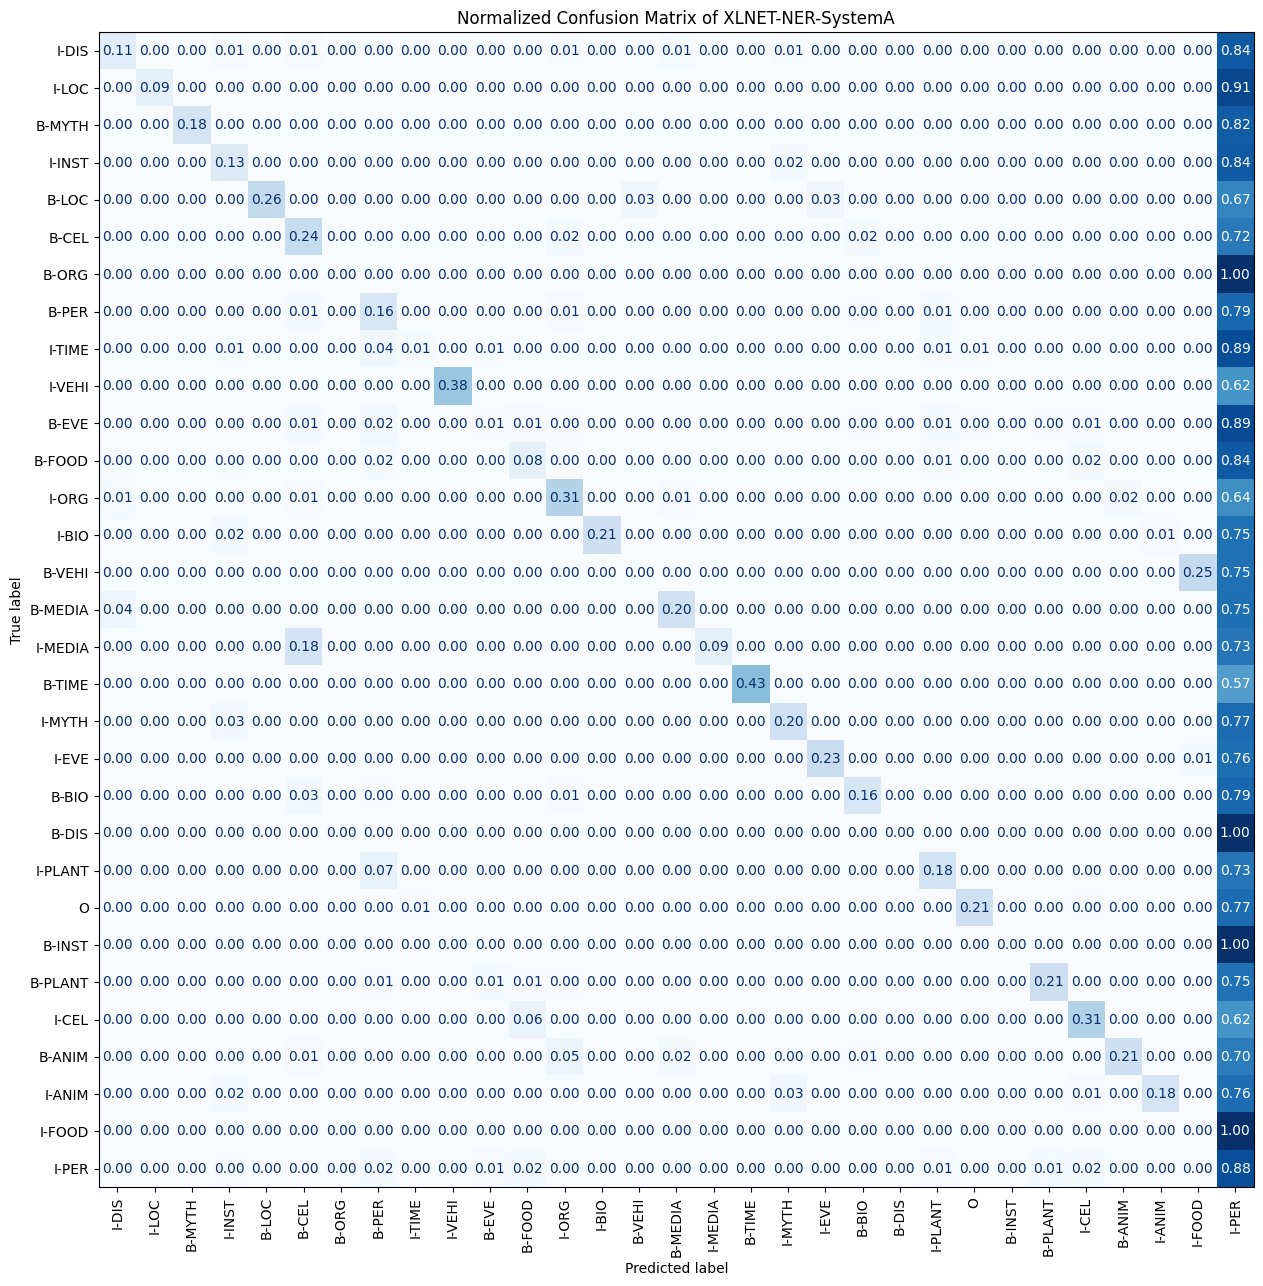

In [145]:
eval_token_list = list(set(eval_df_tokens['labels']))

plot_confusion_matrix(eval_df_tokens["labels"], eval_df_tokens["predicted_label"],
                      eval_token_list)

#### Define & Call Function to Display Example Token Sequences Along With Labels & Losses

In [32]:
def get_samples(df):
    for _, row in df.iterrows():
        labels, preds, tokens, losses = [], [], [], []
        for i, mask in enumerate(row["attention_mask"]):
            if i not in {0, len(row["attention_mask"])}:
                labels.append(row["labels"][i])
                preds.append(row["predicted_label"][i])
                tokens.append(row["input_tokens"][i])
                losses.append(f"{row['loss'][i]:.2f}")
        eval_df_tmp = pd.DataFrame({"tokens": tokens, "labels": labels, 
                               "preds": preds, "losses": losses}).T
        yield eval_df_tmp

eval_df["total_loss"] = eval_df["loss"].apply(sum)
eval_df_tmp = eval_df.sort_values(by="total_loss", ascending=False).head(3)

pd.set_option('display.max_columns', None)

for sample in get_samples(eval_df_tmp):
    display(sample)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37
tokens,▁people,▁may,▁be,▁gambling,▁more,▁than,▁they,▁can,▁afford,▁,",",▁and,▁the,▁big,▁payout,s,▁also,▁lure,▁un,s,av,ory,▁,"""",▁,hy,ena,▁,"""",▁types,▁into,▁the,▁gambling,▁halls,▁,.,<sep>,<cls>
labels,I-DIS,I-DIS,I-DIS,I-DIS,I-DIS,I-DIS,I-DIS,I-DIS,I-DIS,O,IGN,O,O,O,O,IGN,O,O,O,IGN,IGN,IGN,O,IGN,O,IGN,IGN,O,IGN,O,O,O,O,O,O,IGN,IGN,IGN
preds,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,B-ANIM,B-ANIM,I-ANIM,I-ANIM,I-ANIM,O
losses,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,20.16,21.60,22.34,21.88,21.70,19.95,19.58,20.91,19.94,20.05,-0.00,0.00,-0.00,-0.00,-0.00,-0.00,0.00,-0.00,0.00,-0.00,0.00,0.00,0.00,0.01,0.00,14.15,0.00,0.00,1.28,0.00


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37
tokens,▁people,▁may,▁be,▁gambling,▁more,▁than,▁they,▁can,▁afford,▁,",",▁and,▁the,▁big,▁payout,s,▁also,▁lure,▁un,s,av,ory,▁,"""",▁,hy,ena,▁,"""",▁types,▁into,▁the,▁gambling,▁halls,▁,.,<sep>,<cls>
labels,I-DIS,I-DIS,I-DIS,I-DIS,I-DIS,I-DIS,I-DIS,I-DIS,I-DIS,O,IGN,O,O,O,O,IGN,O,O,O,IGN,IGN,IGN,O,IGN,O,IGN,IGN,O,IGN,O,O,O,O,O,O,IGN,IGN,IGN
preds,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O
losses,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,20.16,21.60,22.34,21.88,21.70,19.95,19.58,20.91,19.94,20.05,-0.00,0.00,-0.00,-0.00,-0.00,-0.00,0.00,-0.00,0.00


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67
tokens,▁further,▁up,▁in,▁elevation,▁,",",▁Ban,ana,▁,yu,cca,▁,-,▁,"""",▁Yu,cca,▁,bac,cata,▁,"""",▁,",",▁Mo,ja,ve,▁,yu,cca,▁,-,▁,"""",▁Yu,cca,▁,s,chi,dig,era,▁,"""",▁,",",▁and,▁the,▁Joshua,▁Tree,▁,-,▁,"""",▁Yu,cca,▁,brev,i,folia,▁,"""",▁appear,▁more,▁frequently,▁,.,<sep>,<cls>
labels,O,O,O,O,O,IGN,B-PLANT,IGN,I-PLANT,IGN,IGN,I-PLANT,IGN,I-PLANT,IGN,I-PLANT,IGN,I-PLANT,IGN,IGN,I-PLANT,IGN,O,IGN,B-PLANT,IGN,IGN,I-PLANT,IGN,IGN,I-PLANT,IGN,I-PLANT,IGN,I-PLANT,IGN,I-PLANT,IGN,IGN,IGN,IGN,I-PLANT,IGN,O,IGN,O,O,B-PLANT,I-PLANT,I-PLANT,IGN,I-PLANT,IGN,I-PLANT,IGN,I-PLANT,IGN,IGN,IGN,I-PLANT,IGN,O,O,O,O,IGN,IGN,IGN
preds,O,O,O,O,O,O,B-PLANT,I-PLANT,I-PLANT,I-PLANT,I-PLANT,O,O,O,O,O,O,I-PLANT,I-PLANT,O,O,O,O,O,B-PLANT,I-PLANT,I-PLANT,I-PLANT,I-PLANT,I-PLANT,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,B-PLANT,I-PLANT,O,O,O,O,B-PLANT,O,I-PLANT,O,O,O,O,O,O,O,O,O,O,O,O
losses,-0.00,-0.00,-0.00,-0.00,-0.00,0.00,0.00,0.00,0.00,0.00,0.00,12.83,0.00,13.74,0.00,10.14,0.00,0.67,0.00,0.00,15.34,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,12.32,0.00,14.30,0.00,9.53,0.00,1.72,0.00,0.00,0.00,0.00,17.06,0.00,-0.00,0.00,0.00,0.00,0.00,0.00,15.59,0.00,13.76,0.00,9.69,0.00,0.55,0.00,0.00,0.00,19.10,0.00,0.00,0.00,-0.00,-0.00,0.00,0.00,0.00
